In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Data Preparing

In [2]:
df = pd.read_csv("../data/analysed_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8692 entries, 0 to 8691
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Floor            8692 non-null   float64
 1   NumberOfStoreys  8692 non-null   float64
 2   CeilingHeight    8692 non-null   float64
 3   TargetPrice      8692 non-null   float64
 4   TotalArea        8692 non-null   float64
 5   LivingArea       8692 non-null   float64
 6   KitchenArea      8692 non-null   float64
 7   District         8692 non-null   object 
 8   NearTheSubway    8692 non-null   object 
 9   NumberOfRooms    8692 non-null   int64  
 10  HouseType        8692 non-null   object 
 11  Bathroom         8692 non-null   object 
 12  Balcony          8692 non-null   object 
 13  YearBuilt        8692 non-null   float64
dtypes: float64(8), int64(1), object(5)
memory usage: 950.8+ KB


In [4]:
df['near_the_subway'] = df['near_the_subway'].map({'Yes': 1, 'No': 0})

In [5]:
X = df.drop(['target_price'], axis=1)
y = df['target_price']

In [6]:
y = np.log1p(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6953, 13) (6953,)
(1739, 13) (1739,)


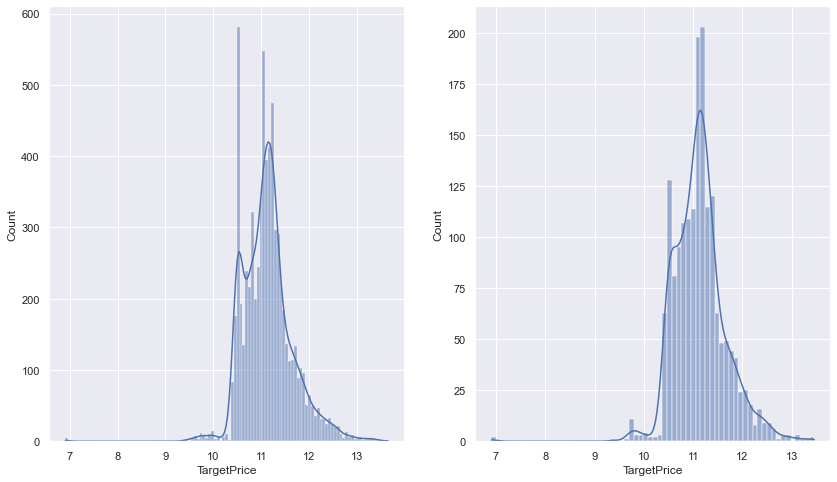

In [8]:
fig = plt.figure(figsize=(14, 8))

ax1 = fig.add_subplot(121)
sns.histplot(y_train, kde=True)
ax2 = fig.add_subplot(122)
sns.histplot(y_test, kde=True)
plt.show()

In [9]:
cat = ['house_type', 'district', 'bathroom', 'balcony']
num = ['year_built', 'floor', 'ceiling_height', 'total_area',
       'living_area', 'kitchen_area', 'number_of_rooms']

In [10]:
column_transformer = ColumnTransformer([
    ("num", StandardScaler(), num), 
    ("cat", OneHotEncoder(), cat), 
])

In [11]:
X_train_prep = column_transformer.fit_transform(X_train)
X_train_prep.shape

(6953, 30)

# Modeling

## Linear Models

In [142]:
lr = LinearRegression()
lr.fit(X_train_prep, y_train)

LinearRegression()

In [143]:
y_pred = lr.predict(X_train_prep)
np.sqrt(mean_squared_error(y_pred, y_train))

0.29876419902486445

In [144]:
scores = cross_val_score(lr, X_train_prep, y_train, 
                         scoring="neg_mean_squared_error", cv=5)
np.sqrt(-scores).mean()

0.3027627976572284

##  XGBoost

In [145]:
xgb_boost = XGBRegressor(n_estimators=20)
xgb_boost.fit(X_train_prep, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [146]:
y_pred = xgb_boost.predict(X_train_prep)
np.sqrt(mean_squared_error(y_pred, y_train))

0.1386931236972141

In [147]:
scores = cross_val_score(xgb_boost, X_train_prep, y_train, 
                         scoring="neg_mean_squared_error", cv=5)
np.sqrt(-scores).mean()

0.2347207980617047

## Light GBM

In [148]:
lgbm_boost = LGBMRegressor(n_estimators=30)
lgbm_boost.fit(X_train_prep, y_train)

LGBMRegressor(n_estimators=30)

In [149]:
y_pred = lgbm_boost.predict(X_train_prep)
np.sqrt(mean_squared_error(y_pred, y_train))

0.19353360368314182

In [150]:
scores = cross_val_score(lgbm_boost, X_train_prep, y_train, 
                         scoring="neg_mean_squared_error", cv=5)
np.sqrt(-scores).mean()

0.22531369194490053

## CatBoost

In [12]:
cat_boost = CatBoostRegressor(verbose=0)
cat_boost.fit(X_train_prep, y_train)

In [13]:
y_pred = cat_boost.predict(X_train_prep)
np.sqrt(mean_squared_error(y_pred, y_train))

0.10401841908814288

In [14]:
scores = cross_val_score(cat_boost, X_train_prep, y_train, 
                         scoring="neg_mean_squared_error", cv=5)
np.sqrt(-scores).mean()

0.20645067054080948

# Hyperparameters tuning

## XGBoost

In [154]:
xgb_grid = {
    'n_estimators': np.arange(20, 40, 5),
    'max_depth': np.arange(3, 9, 2),
    'learning_rate': np.arange(0.05, 0.2, 0.05),
}

In [155]:
xgb_grid_search = GridSearchCV(xgb_boost, xgb_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
xgb_grid_search.fit(X_train_prep, y_train)
xgb_grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 35}

In [156]:
y_pred = xgb_grid_search.predict(X_train_prep)
np.sqrt(mean_squared_error(y_pred, y_train))

0.1447733979938582

In [157]:
scores = cross_val_score(xgb_grid_search, X_train_prep, y_train, 
                         scoring="neg_mean_squared_error", cv=5)
np.sqrt(-scores).mean()

0.2309009661537406

## Light Boost

In [158]:
lgbm_grid = {
    'n_estimators': np.arange(20, 40, 5),
    'num_leaves': np.arange(10, 40, 5), 
    'max_depth': [5, 7, 9]
}

In [159]:
lgbm_grid_search = GridSearchCV(lgbm_boost, lgbm_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
lgbm_grid_search.fit(X_train_prep, y_train)
lgbm_grid_search.best_params_

{'max_depth': 7, 'n_estimators': 35, 'num_leaves': 35}

In [160]:
y_pred = lgbm_grid_search.predict(X_train_prep)
np.sqrt(mean_squared_error(y_pred, y_train))

0.18759172111571576

In [161]:
scores = cross_val_score(lgbm_grid_search, X_train_prep, y_train, 
                         scoring="neg_mean_squared_error", cv=5)
np.sqrt(-scores).mean()

0.22384384713072322

## Test

In [164]:
pipeline_with_predictor = Pipeline([
        ("preparation", column_transformer),
        ("est", xgb_grid_search),
])

In [165]:
y_pred = pipeline_with_predictor.predict(X_test)
np.sqrt(mean_squared_error(y_pred, y_test))

0.23860326959607864